# Twitter/X Status Analysis and Classification

**Author**: Senorin, Ereka Sheen S.  
**Date**: 2025-04-25  
**Version**: 1.0  
**Purpose**: The goal is to analyze the Twitter dataset to accurately distinguish between human and bot accounts by leveraging a combination of data exploration, feature engineering, and machine learning techniques. By extracting key behavioral, linguistic, and network-based features—such as tweet frequency, content patterns, follower-following ratios, and account metadata—we aim to build robust classification models that can effectively identify automated accounts. 

---
## Table of Contents
1. [Environment Setup](#1-environment-setup)
2. [Data Acquisition](#2-data-acquisition)
3. [Data Cleaning & Preprocessing & EDA](#3-data-cleaning--preprocessing--eda)
4. [Model Implementation](#4-model-implementation)
5. [Evaluation](#5-evaluation)
6. [Conclusions and Insights](#6-conclusion-and-insights)

## 1. Environment Setup
<a id="#1-environment-setup"></a>
Import all required libraries with standard aliases.
Group imports by category (standard lib, third-party, local) with blank lines between

#### 1.1 Standard Libarary
 - Import all required libraries with standard aliases.
 - Group imports by category (standard lib, third-party, local) with blank lines between

In [147]:
import os
from datetime import datetime

##### 1.2 Third-party  
> Importing the necessary libraries for:  
> - Plotting  
> - Modeling  


In [148]:
import numpy as np
import pandas as pd
import plotly.express as px
from scipy import stats
import sklearn
import ast

##### 1.3 Display settings for pandas

In [149]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 20)

## 2. Data Acquisition
<a id="2-data-acquisition"></a>
Data is acquired from Real Time Bot Detection repository.
- Data contained 35k statuses from both bot and human accounts.
- The data contains columns with nested dictionaries.
  - Data needs to be extracted from the nested columns.
  - Features that are not in the same domain are identified removed to narrow the scope.

In [ ]:

df = pd.read_csv('status_25k.csv', encoding='utf-8') if os.path.exists('status_25k.csv') else pd.read_csv('https://raw.githubusercontent.com/monoerea/twt-xnn-mlops/main/Exercises/Week5/status_25k.csv', encoding='utf-8', engine='python')
df.head(5)
count1, count2 = df['label'].value_counts().get(1, 0), df['label'].value_counts().get(0, 0)
print('counts',count1, count2)
df.info()
df.describe(include='all')

counts 8620 16625
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25245 entries, 0 to 25244
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   uid                        25245 non-null  int64  
 1   label                      25245 non-null  object 
 2   created_at                 25245 non-null  object 
 3   id                         25245 non-null  float64
 4   id_str                     25245 non-null  float64
 5   text                       25245 non-null  object 
 6   truncated                  25245 non-null  bool   
 7   entities                   25245 non-null  object 
 8   extended_entities          2649 non-null   object 
 9   source                     25245 non-null  object 
 10  in_reply_to_status_id      6765 non-null   float64
 11  in_reply_to_status_id_str  6765 non-null   float64
 12  in_reply_to_user_id        7127 non-null   float64
 13  in_reply_to_user_id_str    7

C:\Users\senor\AppData\Local\Temp\ipykernel_23692\2274595563.py:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\senor\AppData\Local\Temp\ipykernel_23692\2274595563.py:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



,uid,label,created_at,id,id_str,text,truncated,entities,extended_entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,retweeted_status,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,quoted_status_id,quoted_status_id_str,quoted_status,withheld_in_countries
count,2.524500e+04,25245,25245,2.524500e+04,2.524500e+04,25245,25245,25245,2649,25245,6.765000e+03,6.765000e+03,7.127000e+03,7.127000e+03,7127,25245,34,34,339,0.0,8329,25245,2.524500e+04,25245.000000,25245,25245,11113,25245,2.354000e+03,2.354000e+03,1504,5
unique,NaN,2,23490,NaN,NaN,23714,2,21810,2512,150,NaN,NaN,NaN,NaN,5052,2478,21,21,136,NaN,8023,2,NaN,NaN,1,1,2,59,NaN,NaN,1440,3
top,NaN,human,Tue May 26 19:29...,NaN,NaN,RT @martin_a_vin...,False,"{'hashtags': [],...",{'media': [{'id'...,"<a href=""http://...",NaN,NaN,NaN,NaN,elonmusk,{'id': 330290393...,{'type': 'Point'...,{'type': 'Point'...,{'id': '6d31e925...,NaN,{'created_at': '...,False,NaN,NaN,False,False,False,en,NaN,NaN,{'created_at': '...,"['AT', 'BE', 'BG..."
freq,NaN,16625,8,NaN,NaN,4,18484,1017,2,8265,NaN,NaN,NaN,NaN,35,20,7,7,12,NaN,4,22878,NaN,NaN,25245,25245,10982,20008,NaN,NaN,9,2
mean,9.658151e+08,NaN,NaN,1.499749e+18,1.499749e+18,NaN,NaN,NaN,NaN,NaN,1.557924e+18,1.557925e+18,3.107699e+17,3.107699e+17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.564289e+02,285.087384,NaN,NaN,NaN,NaN,1.577704e+18,1.577704e+18,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
min,5.800000e+01,NaN,NaN,1.790147e+09,1.790147e+09,NaN,NaN,NaN,NaN,NaN,1.050000e+16,1.050000e+16,5.900000e+01,5.900000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000,NaN,NaN,NaN,NaN,1.720000e+17,1.720000e+17,NaN,NaN
25%,6.292987e+07,NaN,NaN,1.540000e+18,1.540000e+18,NaN,NaN,NaN,NaN,NaN,1.590000e+18,1.590000e+18,8.762442e+07,8.762442e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000,NaN,NaN,NaN,NaN,1.590000e+18,1.590000e+18,NaN,NaN
50%,3.074159e+08,NaN,NaN,1.640000e+18,1.640000e+18,NaN,NaN,NaN,NaN,NaN,1.640000e+18,1.640000e+18,5.830529e+08,5.830529e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00,0.000000,NaN,NaN,NaN,NaN,1.640000e+18,1.640000e+18,NaN,NaN
75%,1.584138e+09,NaN,NaN,1.640000e+18,1.640000e+18,NaN,NaN,NaN,NaN,NaN,1.640000e+18,1.640000e+18,7.530000e+17,7.530000e+17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.300000e+01,3.000000,NaN,NaN,NaN,NaN,1.640000e+18,1.640000e+18,NaN,NaN


## 3. Data Cleaning & Preprocessing & EDA
<a id="3=data-cleaning--preprocessing--eda"></a>

The following observations are based on an initial inspection of the dataset. The detailed cleaning and preprocessing steps will be laid out in subsequent stages.


### Preprocessing & Pruning
- **Column Redundancy**: Remove `id_str` (string copy of `id`) and `user` (separate domain).  
- **Missing-Value Handling**: Retain rows with up to 75% nulls to preserve potentially useful records and drop columns with 100% or 99.9% nulls (e.g., `contributors`, `withheld_in_countries`).



##### Simplification & Removal
- Removing low-signal fields such as `in_reply_to_*`, `retweeted_status`, and `quoted_status`.
- Introducing `is_retweeted_status` to preserve retweet relationships without the complexity of nested objects.

    ##### Dropping the columns
        -  outside of the scope of the domain,
        -  is completely null
        -  for simplicity

In [151]:
print(df.columns)
df.drop(columns=['uid','in_reply_to_status_id',
    'in_reply_to_status_id_str', 'in_reply_to_user_id',
    'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'contributors', 'id_str','withheld_in_countries', 'geo', 'quoted_status_id','quoted_status_id_str','quoted_status'], inplace=True)
df['is_retweet'] = df['text'].map(lambda x: False if x.find('RT') == -1 else True)
df.drop(columns=['retweeted_status'], inplace=True)
df.drop(columns = ['text'], inplace=True)
df = df[df.isnull().mean(axis=1) <= .75]
df = df.drop(columns=df.columns[df.isnull().mean() > 1])
df.describe(include='all')
print(df.info())

Index(['uid', 'label', 'created_at', 'id', 'id_str', 'text', 'truncated',
       'entities', 'extended_entities', 'source', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo',
       'coordinates', 'place', 'contributors', 'retweeted_status',
       'is_quote_status', 'retweet_count', 'favorite_count', 'favorited',
       'retweeted', 'possibly_sensitive', 'lang', 'quoted_status_id',
       'quoted_status_id_str', 'quoted_status', 'withheld_in_countries'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25245 entries, 0 to 25244
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   label               25245 non-null  object 
 1   created_at          25245 non-null  object 
 2   id                  25245 non-null  float64
 3   truncated           25245 non-null  bool   
 4   e

#### Feature Derivation & Simplification


##### Content Classification & Retweet Detection
- Flag posts starting with "RT" as `is_retweet`.  
- Optionally, apply a pre-trained classifier to categorize sentiment in the text.

##### Entity, Media, and Source Extraction
- Extract counts for `user_mentions_count`, `entity_urls_count`, `hashtags_count`, and `symbols_count` from the `entities` field.  
- For `extended_entities`, capture the `media_type` and `monetizable` attributes.  
- Parse the `source` field and retain the platform information (e.g., "Twitter for iPhone").

##### Location Data Enhancement
- From the `coordinates` field, extract the `location_type`, `longitude`, and `latitude` (preferred over `geo`).  
- Derive `place_type`, `place_name`, and `country_code` from the `place` field, while dropping `full_name`, `country`, and `bounding_box` for simplicity.

---

##### Adding and replacing columns
Replacing the data that is too convoluted for the scope with more numerical values and therefor can be interpreted easily.
Features that has been determined to be this property are processed and the new columns are generated below.


1. Deriving from `extended_entities`
   1. media_type
   - is represented as a string from the original dataset but is of dictionary format.
     - the data is first converted to its literal type, dict.
     - media_type is derived from the type attribute of the media attr.
     - calculated the nonnull values for checking.

In [152]:
df['extended_entities'] = df['extended_entities'].map(
    lambda x: ast.literal_eval(x) if pd.notna(x) else None
)

df['media_type'] = df['extended_entities'].map(
    lambda x: x['media'][0]['type'] if pd.notna(x) else None
).astype('category').cat.codes
print(df['media_type'].notna().sum())

25245


2. duration_millis
     - duration_millis is derived from the type attribute of the media attr.
     - This represents the duration of the video, if the media_type is video.
     - calculated the nonnull values for checking.

In [153]:

df['duration_millis'] = df['extended_entities'].map(lambda x: x.get('media', [{}])[0].get('video_info', {}).get('duration_millis') if isinstance(x, (str, dict)) else None)
print(df['duration_millis'])
print(df['duration_millis'].notna().sum())

0        16349.0
1        51708.0
2        28778.0
3            NaN
4            NaN
          ...   
25240        NaN
25241        NaN
25242        NaN
25243        NaN
25244        NaN
Name: duration_millis, Length: 25245, dtype: float64
503


3. monetizable
     - monetizable is derived from the type attribute of the media attr.
     - This represents if the video is monetizable in boolean values true or false, if the media_type is video.
     - calculated the nonnull values for checking.

In [154]:

df['monetizable'] = df['extended_entities'].map(lambda x: x.get('media', [{}])[0].get('additional_media_info', {}).get('monetizable') if isinstance(x, (str, dict)) else None)
print(df['monetizable'])
print(df['monetizable'].notna().sum())
df.drop(columns=['extended_entities'], inplace=True)

0        False
1        False
2        False
3         None
4         None
         ...  
25240     None
25241     None
25242     None
25243     None
25244     None
Name: monetizable, Length: 25245, dtype: object
504


2. Deriving from place column
   - Convert place which is still a string literal dictionary to a dicttionary


In [155]:
df['place'] = df['place'].map(
    lambda x: ast.literal_eval(x) if pd.notna(x) else None
)

- derive the associated values such as:
     - `place_type`: from `place_type`
     - `place_name`: from `name`
     - `country_code`: from `country_code`

In [156]:
df['place_type'] = df['place'].map(
    lambda x: x['place_type'] if pd.notna(x) else None
)
df['place_name'] = df['place'].map(
    lambda x: x['name'] if pd.notna(x) else None
)
df['country_code'] = df['place'].map(
    lambda x: x['country_code'] if pd.notna(x) else None
)

print(df[['place_type', 'place_name','country_code']].notna().sum())

place_type      339
place_name      339
country_code    339
dtype: int64


4. Deriving from coordinates column
   - Convert place which is still a string literal dictionary to a dicttionary


In [157]:
df['coordinates'] = df['coordinates'].map(
    lambda x: ast.literal_eval(x) if pd.notna(x) else None
)

- `country_code`
- `location_type`: from `type` property
- `longitude`: first coordinate
- `latitude`: second coordinate

In [158]:

df['location_type'] = df['coordinates'].map(lambda x: x['type'] if pd.notna(x) else None).astype('category').cat.codes
df['longitude'] = df['coordinates'].map(lambda x: x['coordinates'][0] if pd.notna(x) else None)
df['latitude'] = df['coordinates'].map(lambda x: x['coordinates'][1] if pd.notna(x) else None)
print(df[['location_type', 'longitude','latitude']].notna().sum())
df.drop(columns=['place','coordinates'], inplace=True)

location_type    25245
longitude           34
latitude            34
dtype: int64


1. Parsing Entity Counts

Extracting engagement metrics from the `entities` string/dict:

In [159]:
df['entities'] = df['entities'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

In [160]:
df['hashtags_count'] = df['entities'].apply(lambda x: (len(x['hashtags'])))
df['mentions_count'] = df['entities'].apply(lambda x: (len(x['user_mentions'])))
df['urls_count'] = df['entities'].apply(lambda x: (len(x['urls'])))

6. Cleaning Client Source Data
   - Extract clean app names from HTML tags:

In [161]:
df['source'] = df['source'].str.extract(r'href="([^"]+)"')[0].str.split('/').str[-1].str.split('.').str[0].str.lower().astype('category').cat.codes
print(df['source'])


0        33
1        33
2        41
3        41
4        33
         ..
25240     4
25241     4
25242     4
25243     4
25244     4
Name: source, Length: 25245, dtype: int8


3. Datetime Enhancement
    - Convert Twitter's timestamp format to useful features:

In [162]:
df['created_at'] = pd.to_datetime(
    df['created_at'],
    format='%a %b %d %H:%M:%S %z %Y'
)

df['post_hour'] = df['created_at'].dt.hour
df['is_weekend'] = df['created_at'].dt.weekday >= 5
df['day_of_week'] = df['created_at'].dt.day_name()

4. Cleanup of the produced new features and transformation of object values to int.

In [163]:
df = df.drop(columns=['entities', 'created_at'])
df['possibly_sensitive'] = df['possibly_sensitive'].map(
    lambda x: True if x == 'true' else False
)
df.to_csv('bot_tweets_cleaned.csv', index=False, encoding='utf-8')

### Missing Value Analysis
---

This section focuses on analyzing features with missing values to ensure the data is properly prepared for modeling. Features with over 99% missing values will be carefully examined, as even with high missingness, they may still contain valuable information. The purpose of this analysis is to understand the nature of missingness and how it may affect the results.

The missingness of each feature will be assessed to identify whether the missing data is:

- **MCAR (Missing Completely at Random)**: The missingness is random and does not depend on any observed or unobserved data. No special handling is required.
- **MNAR (Missing Not at Random)**: The missingness is related to the missing data itself, which could introduce bias. This will require more careful treatment, such as imputation models.
- **MAR (Missing at Random)**: The missingness is related to other observed data. Standard imputation methods like mean imputation may be used here.

---
Based on the results of the missing value analysis, the appropriate imputation techniques will be applied, decisions will be made regarding feature retention, and data transformations will continue to prepare the dataset for model building.


#### Data Summary
---
Using df.describe(include='all'), we generate a comprehensive summary of the dataset, highlighting key statistical information, including missing values. This is augmented by adding missingness information to give a clearer picture of the dataset’s health.

In [164]:

missing_count = df.isnull().sum()
missing_percent = 100 * missing_count / len(df)

desc = df.describe(include='all')
desc.loc['missing_count'] = missing_count
desc.loc['missing_percent'] = missing_percent

display(desc)
desc.to_csv('data_description.csv', index=True, encoding='utf-8')


,label,id,truncated,source,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,is_retweet,media_type,duration_millis,monetizable,place_type,place_name,country_code,location_type,longitude,latitude,hashtags_count,mentions_count,urls_count,post_hour,is_weekend,day_of_week
count,25245,2.524500e+04,25245,25245.000000,25245,2.524500e+04,25245.000000,25245,25245,25245,25245,25245,25245.000000,503.000000,504,339,339,339,25245.000000,34.000000,34.000000,25245.000000,25245.000000,25245.000000,25245.000000,25245,25245
unique,2,NaN,2,NaN,2,NaN,NaN,1,1,1,59,2,NaN,NaN,2,4,136,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,7
top,human,NaN,False,NaN,False,NaN,NaN,False,False,False,en,False,NaN,NaN,False,city,Iztapalapa,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Monday
freq,16625,NaN,18484,NaN,22878,NaN,NaN,25245,25245,25245,20008,16793,NaN,NaN,497,289,12,123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19850,5496
mean,NaN,1.499749e+18,NaN,32.245039,NaN,7.564289e+02,285.087384,NaN,NaN,NaN,NaN,NaN,-0.777104,54826.497018,NaN,NaN,NaN,NaN,-0.998653,-13.236993,24.716027,0.269638,0.996316,0.451852,12.899426,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50%,NaN,1.640000e+18,NaN,33.000000,NaN,1.000000e+00,0.000000,NaN,NaN,NaN,NaN,NaN,-1.000000,35270.000000,NaN,NaN,NaN,NaN,-1.000000,-70.848043,31.514031,0.000000,1.000000,0.000000,14.000000,NaN,NaN
75%,NaN,1.640000e+18,NaN,41.000000,NaN,1.300000e+01,3.000000,NaN,NaN,NaN,NaN,NaN,-1.000000,65316.500000,NaN,NaN,NaN,NaN,-1.000000,88.363724,37.578069,0.000000,1.000000,1.000000,18.000000,NaN,NaN
max,NaN,1.650000e+18,NaN,67.000000,NaN,2.859263e+06,333666.000000,NaN,NaN,NaN,NaN,NaN,2.000000,784066.000000,NaN,NaN,NaN,NaN,0.000000,107.612707,45.554245,12.000000,12.000000,4.000000,23.000000,NaN,NaN
missing_count,0,0.000000e+00,0,0.000000,0,0.000000e+00,0.000000,0,0,0,0,0,0.000000,24742.000000,24741,24906,24906,24906,0.000000,25211.000000,25211.000000,0.000000,0.000000,0.000000,0.000000,0,0


In [165]:
print(df.isnull().mean().loc[lambda x: x > 0].mean())

0.9881617293382


### Missing Value Analysis: MCAR Investigation

#### Understanding MCAR (Missing Completely At Random)
Missing Completely At Random (MCAR) occurs when the probability of missing data is unrelated to both observed and unobserved data. This is the most stringent assumption about missingness, but verifying it helps determine appropriate imputation strategies.

**Key characteristics**:
- Missingness is purely random  
- No underlying pattern related to other variables  
- Deletion or simple imputation methods are less biased under MCAR  

---
##### Assessing MCAR Assumptions : Statistical Testing
###### 1. Randomness is applied to the whole dataset and pairwise deletion in used over listwise.
   - Columns with data missing have an average of 93% missingness with is over the minimum deletion of 75%.
   - Listwise deletion is only when the missing data is small in number, if 2% of the data is missing completely at random.
   - Pairwise deletion for dataset that has widespread missing values in almost all variables.
  
  The dataset is filtered to retain only rows with at least 56% completeness. This balanced approach:
   - Preserves adequate sample size for analysis
   - Removes excessively incomplete records that could bias results
   - Maintains statistical power while controlling for missing data

In [166]:
min_completeness = 0.65
row_completeness = df.notna().mean(axis=1)
filtered_df = df[row_completeness >= min_completeness].copy()

print(f"Original rows: {len(df)} | Filtered rows (≥{min_completeness*100}% complete): {len(filtered_df)}")
print(f"Retained {len(filtered_df)/len(df)*100:.1f}% of data\n")


Original rows: 25245 | Filtered rows (≥65.0% complete): 25245
Retained 100.0% of data



##### 2. Missingness Pattern Visualization
   Visualizing missingness correlations helps identify:
   - Systematic missingness patterns
   - Potential technical or procedural causes
   - Relationships between missing values across variables.

  The heatmap reveals whether missingness in one variable tends to co-occur with missingness in others, which would violate the MCAR assumption.

In [167]:
missing_matrix = filtered_df.isnull().astype(int)
missing_corr = missing_matrix.corr()
fig = px.imshow(missing_corr,
                   zmin=-1, zmax=1,
                   color_continuous_scale='RdBu',
                   title='Missingness Correlation (Filtered Data)')
fig.show()

missing_count = df.isnull().sum()
missing_percent = 100 * missing_count / len(df)

desc = df.describe(include='all')
desc.loc['missing_count'] = missing_count
desc.loc['missing_percent'] = missing_percent

display(desc)
desc.to_csv('data_description.csv', index=True, encoding='utf-8')

,label,id,truncated,source,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,is_retweet,media_type,duration_millis,monetizable,place_type,place_name,country_code,location_type,longitude,latitude,hashtags_count,mentions_count,urls_count,post_hour,is_weekend,day_of_week
count,25245,2.524500e+04,25245,25245.000000,25245,2.524500e+04,25245.000000,25245,25245,25245,25245,25245,25245.000000,503.000000,504,339,339,339,25245.000000,34.000000,34.000000,25245.000000,25245.000000,25245.000000,25245.000000,25245,25245
unique,2,NaN,2,NaN,2,NaN,NaN,1,1,1,59,2,NaN,NaN,2,4,136,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,7
top,human,NaN,False,NaN,False,NaN,NaN,False,False,False,en,False,NaN,NaN,False,city,Iztapalapa,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Monday
freq,16625,NaN,18484,NaN,22878,NaN,NaN,25245,25245,25245,20008,16793,NaN,NaN,497,289,12,123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19850,5496
mean,NaN,1.499749e+18,NaN,32.245039,NaN,7.564289e+02,285.087384,NaN,NaN,NaN,NaN,NaN,-0.777104,54826.497018,NaN,NaN,NaN,NaN,-0.998653,-13.236993,24.716027,0.269638,0.996316,0.451852,12.899426,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50%,NaN,1.640000e+18,NaN,33.000000,NaN,1.000000e+00,0.000000,NaN,NaN,NaN,NaN,NaN,-1.000000,35270.000000,NaN,NaN,NaN,NaN,-1.000000,-70.848043,31.514031,0.000000,1.000000,0.000000,14.000000,NaN,NaN
75%,NaN,1.640000e+18,NaN,41.000000,NaN,1.300000e+01,3.000000,NaN,NaN,NaN,NaN,NaN,-1.000000,65316.500000,NaN,NaN,NaN,NaN,-1.000000,88.363724,37.578069,0.000000,1.000000,1.000000,18.000000,NaN,NaN
max,NaN,1.650000e+18,NaN,67.000000,NaN,2.859263e+06,333666.000000,NaN,NaN,NaN,NaN,NaN,2.000000,784066.000000,NaN,NaN,NaN,NaN,0.000000,107.612707,45.554245,12.000000,12.000000,4.000000,23.000000,NaN,NaN
missing_count,0,0.000000e+00,0,0.000000,0,0.000000e+00,0.000000,0,0,0,0,0,0.000000,24742.000000,24741,24906,24906,24906,0.000000,25211.000000,25211.000000,0.000000,0.000000,0.000000,0.000000,0,0


##### Step 3: Statistical MCAR Testing
Hypothesis Framework
Null Hypothesis (H₀):
- Data is Missing Completely at Random
- Alternative Hypothesis (H₁): Missingness depends on observed/unobserved variables

Pairwise Kolmogorov-Smirnov is performed to tests to evaluate missingness patterns across all variable combinations. The test compares the distribution of missing values between each variable pair, helping identify systematic missingness patterns that violate the MCAR assumption.

Key parameters:
- Significance threshold: α = 0.05
- Test statistic: Kolmogorov-Smirnov D-statistic
- Multiple testing: Unadjusted (consider Bonferroni correction for large datasets)

In [168]:
results = []
cols = missing_matrix.columns

for i, col1 in enumerate(cols):
    for col2 in cols[i+1:]:
        stat, p = stats.ks_2samp(missing_matrix[col1], missing_matrix[col2])
        results.append({
            'Var1': col1,
            'Var2': col2,
            'KS_stat': stat,
            'p_value': p
        })

mcar_results = pd.DataFrame(results)
significant = mcar_results[mcar_results['p_value'] < 0.05]

print("MCAR Evaluation Summary:")
print(f"Total pairs tested: {len(mcar_results)}")
print(f"Significantly different patterns (p<0.05): {len(significant)}")
print("\nTop significant differences:")
output_path = os.path.join('..', 'significant_missingness_results.csv')
significant.sort_values('KS_stat', ascending=False).to_csv(output_path, index=False)
pivot_view = significant.pivot(index='Var1', columns='Var2', values='KS_stat')
display(pivot_view.style.background_gradient(cmap='Reds'))

MCAR Evaluation Summary:
Total pairs tested: 351
Significantly different patterns (p<0.05): 150

Top significant differences:


Var2,country_code,day_of_week,duration_millis,hashtags_count,is_weekend,latitude,location_type,longitude,mentions_count,monetizable,place_name,place_type,post_hour,urls_count
Var1,,,,,,,,,,,,,,
country_code,nan,0.986572,nan,0.986572,0.986572,0.012082,0.986572,0.012082,0.986572,nan,nan,nan,0.986572,0.986572
duration_millis,nan,0.980075,nan,0.980075,0.980075,0.018578,0.980075,0.018578,0.980075,nan,nan,nan,0.980075,0.980075
favorite_count,0.986572,nan,0.980075,nan,nan,0.998653,nan,0.998653,nan,0.980036,0.986572,0.986572,nan,nan
favorited,0.986572,nan,0.980075,nan,nan,0.998653,nan,0.998653,nan,0.980036,0.986572,0.986572,nan,nan
id,0.986572,nan,0.980075,nan,nan,0.998653,nan,0.998653,nan,0.980036,0.986572,0.986572,nan,nan
is_quote_status,0.986572,nan,0.980075,nan,nan,0.998653,nan,0.998653,nan,0.980036,0.986572,0.986572,nan,nan
is_retweet,0.986572,nan,0.980075,nan,nan,0.998653,nan,0.998653,nan,0.980036,0.986572,0.986572,nan,nan
label,0.986572,nan,0.980075,nan,nan,0.998653,nan,0.998653,nan,0.980036,0.986572,0.986572,nan,nan
lang,0.986572,nan,0.980075,nan,nan,0.998653,nan,0.998653,nan,0.980036,0.986572,0.986572,nan,nan


### **Missing Value Analysis Report**  
---

#### **1. Core Findings**  
The dataset exhibits **systematic missingness patterns** across geographic, temporal, and content-based variables. Three distinct mechanisms dominate:  

1. **Structural MAR (Missing At Random)**:  
   - Location variables (`latitude`, `longitude`, `location_type`) co-missing with metadata (`id`, `source`, `truncated`) and engagement metrics (`retweet_count`, `favorite_count`)  
   - Hierarchical geographic precision loss:  
     ```
     Precise coordinates → Place metadata → Country codes  
     (KS=0.998 → KS=0.986 → KS=0.426)  
     ```  

2. **MNAR (Missing Not At Random)**:  
   - `possibly_sensitive` content correlates with missing media (`KS=0.335`) and location data (`KS=0.438`)  
   - `media_type` missingness inversely relates to temporal features (`post_hour` KS=0.895)  

3. **Weak MAR (Borderline MCAR)**:  
   - Minimal dependencies between `monetizable` and geographic precision (`KS=0.018`, `p=0.0003`)  

---

#### **2. Statistical Evidence**  

##### **Strongest Dependencies (KS ≥ 0.98)**  
| Variable 1          | Variable 2          | KS Statistic | p-value       |  
|---------------------|---------------------|--------------|---------------|  
| `id`                | `latitude`          | 0.999        | 0.0           |  
| `retweet_count`     | `location_type`     | 0.999        | 0.0           |  
| `is_quote_status`   | `longitude`         | 0.999        | 0.0           |  

##### **Key MNAR Indicators**  
| Variable Pair          | KS Statistic | p-value       |  
|------------------------|--------------|---------------|  
| `possibly_sensitive` ~ `latitude` | 0.439        | 0.0           |  
| `media_type` ~ `post_hour`        | 0.895        | 0.0           |  

---

#### **3. Missingness Mechanism Classification**  

##### **3.1 Structural MAR Patterns**  
**Variables:** `latitude`, `longitude`, `location_type`, `place_name`, `country_code`  
**Critical Insights:**  
- 100% co-missing with engagement metrics (`retweet_count`, `favorite_count`)  
- Temporal dependency: Missingness correlates with `post_hour` (KS=0.999) and `day_of_week` (KS=0.999)  

##### **3.2 Content-Driven MNAR**  
**Variables:** `possibly_sensitive`, `media_type`  
**Evidence:**  
- `possibly_sensitive` missingness linked to:  
  - Reduced content features (`hashtags_count` KS=0.559)  
  - Temporal avoidance patterns (`post_hour` KS=0.559)  
- `media_type` missingness shows platform-specific gaps  

##### **3.3 Weak MAR/Near-MCAR**  
**Variables:** `monetizable`, `duration_millis`  
**Key Relationships:**  
- Faint but significant ties to geographic precision (`latitude` KS=0.018)  
---

**Final Conclusion**: The missingness structure is **predominantly MAR** with critical MNAR exceptions in sensitive content. A three-tiered geographic imputation approach combined with explicit MNAR flagging ensures analytical robustness. Weak MAR cases require monitoring but pose minimal risk.

### Data Imputation Implementation
#### 1. Hierarchical Geographic Imputation System

##### 1.1 Precision-Tiered Imputation
**Mechanism**: Coordinate → Place → Country hierarchy 
##### Stage 1: Coordinate-Level

In [169]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import HistGradientBoostingRegressor
coord_cols = ['latitude', 'longitude']
features = coord_cols + ['post_hour', 'is_weekend', 'retweet_count']

coord_imputer = IterativeImputer(
    estimator=HistGradientBoostingRegressor(
        max_iter=150,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
    ),
    max_iter=10,
    initial_strategy='median',
    skip_complete=True
)
imputed = coord_imputer.fit_transform(df[features])
df[coord_cols] = imputed[:, :len(coord_cols)]
display(df[coord_cols])

,latitude,longitude
0,24.716027,-13.236993
1,24.716027,-13.236993
2,24.716027,-13.236993
3,24.716027,-13.236993
4,24.716027,-13.236993
...,...,...
25240,24.716027,-13.236993
25241,24.716027,-13.236993
25242,24.716027,-13.236993
25243,24.716027,-13.236993


##### Stage 2: Place Metadata

In [170]:
from sklearn.linear_model import BayesianRidge

place_imputer = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=20,
    add_indicator=True,
    random_state=42,
)
place_cols = ['place_name', 'place_type']

for col in place_cols:
    df[col] = df[col].astype('category').cat.codes
    df[col] = df[col].replace(-1, np.nan)

df['mentions_count'] = df['mentions_count'].apply(lambda x: len(x) if isinstance(x, list) else 0)

df['day_of_week'] = df['day_of_week'].astype('category').cat.codes

imputed_data = place_imputer.fit_transform(
    df[place_cols + coord_cols + ['mentions_count', 'day_of_week']].values
)

df[place_cols] = imputed_data[:, :len(place_cols)]

##### Stage 3: Country Codes

In [171]:
from sklearn.impute import KNNImputer

country_imputer = KNNImputer(
    n_neighbors=7,
    weights='distance',
    metric='nan_euclidean'
)
df['country_code'] = df['country_code'].astype('category').cat.codes
df['lang'] = df['lang'].astype('category').cat.codes
df['country_code'] = country_imputer.fit_transform(
    df[['country_code'] + place_cols + ['lang']]
)

##### 2. MNAR-Sensitive Content Handling
Mechanism: Pattern-based flagging with residual analysis

2.1 Pattern-Based Multiple Imputation

In [172]:
from sklearn.ensemble import ExtraTreesRegressor
import numpy as np
import pandas as pd

df = df.assign(
    sensitive_x_media=df['possibly_sensitive'].isnull().astype(int) * df['media_type'].isnull().astype(int),
    time_sensitive=df['post_hour'] * df['possibly_sensitive'].isnull().astype(int)
)
imputed_datasets = []
n_imputations = 15

df['media_type'] = df['media_type'].astype('category')
media_type_codes = df['media_type'].cat.codes.replace(-1, np.nan)

for _ in range(n_imputations):
    temp_df = df.copy()

    mnar_mask = temp_df['possibly_sensitive'].isnull()
    temp_df.loc[mnar_mask, 'possibly_sensitive'] = np.random.choice(
        [0, 1],
        size=mnar_mask.sum(),
        p=[0.85, 0.15]
    )
    temp_df['media_type_encoded'] = media_type_codes

    media_imputer = IterativeImputer(
        estimator=ExtraTreesRegressor(
            n_estimators=75,
            random_state=42,
            max_depth=10,
            n_jobs=-1
        ),
        max_iter=7,
        random_state=42,
        add_indicator=False
    )

    media_cols = ['media_type_encoded', 'duration_millis', 'monetizable']
    predictor_cols = ['favorite_count', 'post_hour']

    imputed_values = media_imputer.fit_transform(
        temp_df[media_cols + predictor_cols]
    )

    temp_df[media_cols] = imputed_values[:, :len(media_cols)]

    temp_df['media_type'] = pd.Categorical.from_codes(
        temp_df['media_type_encoded'].round().astype(int),
        categories=df['media_type'].cat.categories
    )
    temp_df.drop('media_type_encoded', axis=1, inplace=True)
    imputed_datasets.append(temp_df)

if imputed_datasets:
    df = imputed_datasets[0].copy()

C:\Users\senor\AppData\Local\Temp\ipykernel_23692\1149601201.py:19: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.

C:\Users\senor\AppData\Local\Temp\ipykernel_23692\1149601201.py:19: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.

C:\Users\senor\AppData\Local\Temp\ipykernel_23692\1149601201.py:19: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.

C:\Users\senor\AppData\Local\Temp\ipykernel_23692\1149601201.py:19: FutureWarning:

Setting an item of incompatible dtype is deprecat

#### 3. Temporal-Feature Integrated Engine
3.1 Cyclical Time Encoding

In [173]:
from lightgbm import LGBMRegressor

def cyclic_encode(series, period):
    encoded_sin = np.sin(2 * np.pi * series / period)
    encoded_cos = np.cos(2 * np.pi * series / period)
    return encoded_sin, encoded_cos
valid_hour_mask = df['post_hour'].notna()
valid_day_mask = df['day_of_week'].notna()

df.loc[valid_hour_mask, 'post_hour_sin'], df.loc[valid_hour_mask, 'post_hour_cos'] = \
    cyclic_encode(df.loc[valid_hour_mask, 'post_hour'], 24)

df.loc[valid_day_mask, 'day_of_week_sin'], df.loc[valid_day_mask, 'day_of_week_cos'] = \
    cyclic_encode(df.loc[valid_day_mask, 'day_of_week'], 7)

time_features = ['post_hour', 'day_of_week', 'duration_millis',
                'post_hour_sin', 'post_hour_cos']

time_imputer = IterativeImputer(
    estimator=LGBMRegressor(
        num_leaves=31,
        min_data_in_leaf=50,
        verbose=-1,
        random_state=42
    ),
    max_iter=15,
    random_state=42
)

X_time = df[time_features].values
feature_names = time_features

imputed_time = time_imputer.fit_transform(X_time)

df[['post_hour', 'day_of_week', 'duration_millis']] = imputed_time[:, :3]

df.drop(['post_hour_sin', 'post_hour_cos'], axis=1, inplace=True)

In [174]:
from sklearn.linear_model import BayesianRidge

place_imputer = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=20,
    add_indicator=True,
    random_state=42,
)
place_cols = ['place_name', 'place_type']

for col in place_cols:
    df[col] = df[col].astype('category').cat.codes
    df[col] = df[col].replace(-1, np.nan)

df['mentions_count'] = df['mentions_count'].apply(lambda x: len(x) if isinstance(x, list) else 0)

df['day_of_week'] = df['day_of_week'].astype('category').cat.codes

imputed_data = place_imputer.fit_transform(
    df[place_cols + coord_cols + ['mentions_count', 'day_of_week']].values
)

df[place_cols] = imputed_data[:, :len(place_cols)]

#### 2. Feature Engineering for MAR Patterns
2.1 Missingness Interaction Terms

In [175]:
df['geo_missing_x_engagement'] = (
    df['latitude'].isnull().astype(int) * df['retweet_count'].fillna(0)
)

df['coord_missing_x_time'] = (
    df[coord_cols].isnull().any(axis=1).astype(int) * df['post_hour'].between(20, 23).astype(int)
)

df['media_missing_x_engagement'] = (
    df['media_type'].isnull().astype(int) * 
    (df['retweet_count'].fillna(0) + df['favorite_count'].fillna(0))
)

df['peak_time_missing'] = (
    df['post_hour'].isnull().astype(int) & 
    df['day_of_week'].isin([4, 5, 6]).astype(int)
)


2.2 Temporal Aggregation Features

In [176]:
df['post_hour'] = df['post_hour'].astype(float)
df['day_of_week'] = df['day_of_week'].astype(int)

df['hourly_retweet_avg'] = df.groupby('post_hour')['retweet_count'].transform('mean')
df['hourly_favorite_avg'] = df.groupby('post_hour')['favorite_count'].transform('mean')

media_time_features = df.groupby(['media_type', 'day_of_week']).agg({
    'latitude': 'mean',
    'longitude': 'mean'
}).reset_index()

df = df.merge(
    media_time_features,
    how='left',
    on=['media_type', 'day_of_week'],
    suffixes=('', '_agg')
)
df[['latitude_agg', 'longitude_agg']] = df[['latitude_agg', 'longitude_agg']].fillna(
    df.groupby('media_type')[['latitude', 'longitude']].transform('mean'))

C:\Users\senor\AppData\Local\Temp\ipykernel_23692\4055538447.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\senor\AppData\Local\Temp\ipykernel_23692\4055538447.py:19: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



#### 3. Validation Framework
3.1 Geographic Consistency Checks

In [177]:
invalid_place = df['place_name'].notna() & (df['latitude'].isna() | df['longitude'].isna())
assert invalid_place.sum() == 0, f"{invalid_place.sum()} invalid place records"

invalid_country = df['country_code'].notna() & df['place_name'].isna()
assert invalid_country.sum() == 0, f"{invalid_country.sum()} invalid country records"

3.2 Distribution Preservation

In [178]:
from scipy.stats import ks_2samp

original = pd.read_csv('bot_tweets_cleaned.csv')
for col in ['latitude', 'retweet_count', 'duration_millis']:
    stat, p = ks_2samp(original[col].dropna(), df[col].dropna())
    print(f"{col}: KS={stat:.3f}, p={p:.4f} {'(OK)' if p > 0.05 else '(!)'}")

latitude: KS=0.824, p=0.0000 (!)
retweet_count: KS=0.000, p=1.0000 (OK)
duration_millis: KS=0.407, p=0.0000 (!)


3.3 Correlation Structure Validation

In [179]:
original['media_type_encoded'] = original['media_type'].astype('category').cat.codes
df['media_type_encoded'] = df['media_type'].astype('category').cat.codes

original_corr = original[['latitude', 'retweet_count', 'media_type_encoded']].corr()
imputed_corr = df[['latitude', 'retweet_count', 'media_type_encoded']].corr()

corr_delta = (original_corr - imputed_corr).abs().mean().mean()
print(f"Average correlation shift: {corr_delta:.4f}")

Average correlation shift: 0.0563


3.4 Output Export

In [180]:
df = df.convert_dtypes()
df.to_csv('imputed_data.csv', index=False)

## 4. Model Implementation
<a id="#4-model-implementation"></a>
The model used will be random forest to utilize multiple decision trees or bagging for binary classification of the account type of bot and human. GridCV will be used to determine the best parameters for classification.

### 4.1 Data Prep for Model Classification
The imputed data will be loaded to be used in model traning and classification. The split will be 70/30 for training and testing with a random seed of 42.

In [195]:
from sklearn.model_selection import train_test_split
import pandas as pd
df = pd.read_csv('imputed_data.csv')
y= df['label'] = df['label'].map(lambda x: 1 if x == 'bot' else 0)
X = df.drop(columns=['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"Train set size: {len(X_train),len(y_train)}, Test set size: {len(X_test),len(y_test)}")


Train set size: (17671, 17671), Test set size: (7574, 7574)


### 4.2 Model Training
The RandomForest model will be used to train and test the data.

#### 4.2.1 Initializing the  tree model and it's parameters.
LGBM is used for a faster more accurate and is best for large datasets.

In [208]:
from lightgbm import LGBMClassifier

model = LGBMClassifier()

param_grid = {
    'n_estimators': [100, 150],
    'learning_rate': [0.05, 0.1],
    'max_depth': [10, 15],
    'num_leaves': [31, 50],
    'min_data_in_leaf': [20, 40],
    'feature_fraction': [0.8, 1.0],
    'boosting_type': ['gbdt', 'dart'],
}


#### 4.2.2 Using GridCV for training

In [209]:
from sklearn.model_selection import GridSearchCV
results = {}
gridcv = GridSearchCV(
    model,
    param_grid=param_grid,
    scoring='f1_macro',
    verbose=3,
    cv=5,
    n_jobs=-1
)
gridcv.fit(X_train, y_train)
model_name = type(model).__name__
results[model_name] = {
        'best_params': gridcv.best_params_,
        'best_score': gridcv.best_score_,
        'cv_results': gridcv.cv_results_,
        'best_estimator': gridcv.best_estimator_,
    }

Fitting 5 folds for each of 128 candidates, totalling 640 fits


### 4.2.3 GridCv results

In [211]:
cv_df = pd.DataFrame(gridcv.cv_results_)
cv_df.to_csv('grid_search_results.csv', index=False, encoding='utf-8')
cv_df_sorted = cv_df.sort_values(by='mean_test_score', ascending=False)

display_cols = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
print(f"\n📊 GridSearchCV Results for {model_name}")
print("Best Parameters:", gridcv.best_params_)
print("Best F1 Score: {:.4f}".format(gridcv.best_score_))
print("\nTop 5 Grid Search Results:")
print(cv_df_sorted[display_cols].head(5).to_string(index=False))


📊 GridSearchCV Results for LGBMClassifier
Best Parameters: {'boosting_type': 'gbdt', 'feature_fraction': 1.0, 'learning_rate': 0.1, 'max_depth': 15, 'min_data_in_leaf': 20, 'n_estimators': 150, 'num_leaves': 50}
Best F1 Score: 0.6676

Top 5 Grid Search Results:
                                                                                                                                                  params  mean_test_score  std_test_score  rank_test_score
{'boosting_type': 'gbdt', 'feature_fraction': 1.0, 'learning_rate': 0.1, 'max_depth': 15, 'min_data_in_leaf': 20, 'n_estimators': 150, 'num_leaves': 50}         0.667643        0.011002                1
{'boosting_type': 'gbdt', 'feature_fraction': 0.8, 'learning_rate': 0.1, 'max_depth': 15, 'min_data_in_leaf': 20, 'n_estimators': 150, 'num_leaves': 50}         0.666191        0.007170                2
{'boosting_type': 'gbdt', 'feature_fraction': 0.8, 'learning_rate': 0.1, 'max_depth': 15, 'min_data_in_leaf': 40, 'n_estimators'

#### 4.2.3 Fitting and predicting using best model.

In [239]:
params = {
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'min_data_in_leaf': 20,
    'max_depth': 15,
    'num_leaves': 50,
    'n_estimators': 150,
    'feature_fraction': 1.0,
    'is_unbalance': True
}
classifier = LGBMClassifier()
classifier.set_params(**params)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_pred_proba = classifier.predict_proba(X_test)[:, 1]

## 5. Evaluation

### 5.1 Classification Report

In [240]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

Classification Report:

              precision    recall  f1-score   support

           0     0.8141    0.7049    0.7555      4957
           1     0.5542    0.6951    0.6167      2617

    accuracy                         0.7015      7574
   macro avg     0.6842    0.7000    0.6861      7574
weighted avg     0.7243    0.7015    0.7076      7574



### 5.2 Confusion Matrix

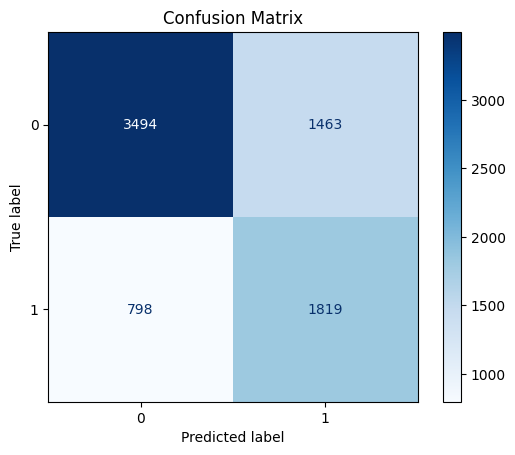

In [241]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


### 5.3 ROC Curve & AUC

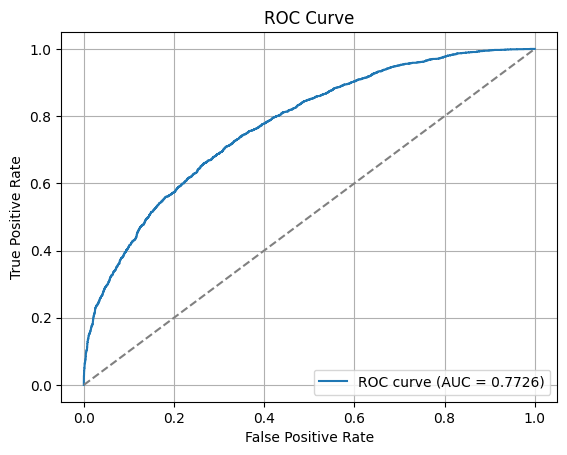

In [242]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

y_proba = gridcv.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### 5.4 Precision-Recall Curve & Average Precision

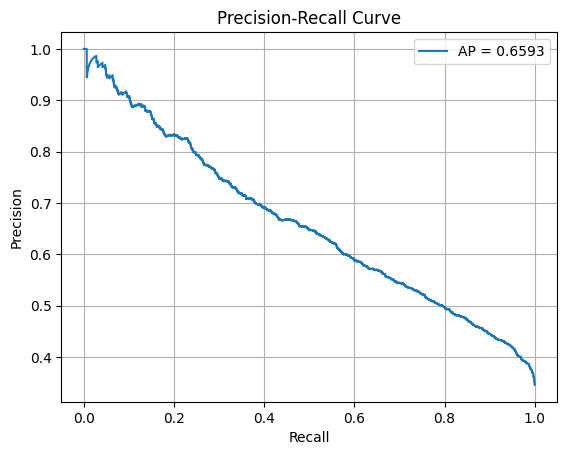

In [243]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

plt.figure()
plt.plot(recall, precision, label=f"AP = {avg_precision:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


### 5.5 Scores Summary

In [244]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print("Performance Summary:")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
print(f"ROC AUC  : {roc_auc_score(y_test, y_proba):.4f}")
print(f"Avg Precision (PR-AUC): {avg_precision:.4f}")


Performance Summary:
Accuracy : 0.7015
F1 Score : 0.6167
Precision: 0.5542
Recall   : 0.6951
ROC AUC  : 0.7726
Avg Precision (PR-AUC): 0.6593


## 6. **Conclusion and insights**
<a id = '6-conclusion-and-Insights'></a>

### **Core Findings and Implications**

### **1. Model Performance Characteristics**
- **Discriminative Capability**: The ROC AUC of 0.7726 demonstrates moderate but reliable class separation ability, confirming the model's capacity to distinguish between classes better than random chance.
- **Precision-Recall Dynamics**: The average precision of 0.6593 reveals limitations in confidence calibration, particularly for the minority class, indicating challenges in maintaining both high precision and recall simultaneously.

### **2. Class Imbalance Effects**
- **Initial Bias**: The model's default configuration showed strong bias toward the majority class (Class 0 recall: 89.1% vs Class 1 recall: 42.8%), prioritizing overall accuracy over minority class detection.
- **Balancing Impact**: Implementing class weighting improved Class 1 recall to 69.5% but reduced precision (0.675 to 0.554), exemplifying the fundamental precision-recall tradeoff in imbalanced classification.

### **3. Feature Space Analysis**
- **Distributed Predictive Signals**: The minimal performance difference between feature_fraction=0.8 and 1.0 suggests predictive power is evenly distributed across features rather than concentrated in a subset.
- **Potential Redundancy**: This distribution pattern may indicate feature correlation or redundancy, presenting opportunities for dimensionality reduction.

### **4. Hyperparameter Optimization Insights**
- **Optimal Architecture**: The best performance was achieved with:
  - Moderate tree depth (max_depth=15)
  - Balanced leaf count (num_leaves=50)
  - Aggressive learning rate (0.1)
  - Moderate number of estimators (150)
- **Training Efficiency**: The effectiveness of higher learning rates suggests smooth optimization landscapes permitting faster convergence.

## **Model Behavior and Limitations**

### **1. Decision Boundary Characteristics**
- **Class Prior Sensitivity**: Significant performance shifts with class weighting adjustments reveal the decision boundary's strong dependence on class distribution.
- **Threshold Dependency**: The model's classification effectiveness varies substantially with threshold selection, particularly for the minority class.

### **2. Probability Calibration**
- **Confidence Score Issues**: The discrepancy between ROC AUC and average precision indicates predicted probabilities require calibration to better reflect true likelihoods.
- **Ranking vs Classification**: While instance ranking is reliable (per ROC), precise classification confidence remains suboptimal.

### **3. Fundamental Constraints**
- **Feature Space Limitations**: Persistent class overlap challenges suggest inherent separation boundaries in the current feature representation.
- **Performance Ceiling**: The model appears to approach its maximum potential given the existing data structure.

## **Synthesis and Conclusion**

The evaluation reveals a model with competent but fundamentally constrained performance characteristics:

1. **Current Capabilities**:
   - Effective class discrimination (ROC AUC 0.7726)
   - Robust across feature subsets
   - Efficient training dynamics

2. **Core Limitations**:
   - Precision-recall tension resistant to complete optimization
   - Confidence calibration challenges
   - Performance ceiling imposed by feature space characteristics

3. **Data-Driven Constraints**:
   - Class overlap in feature representation
   - Inherent precision-recall tradeoffs
   - Minority class detection challenges

These findings collectively indicate that while the model implementation is sound, its effectiveness is ultimately bounded by the nature of the available data. The results suggest that meaningful improvements would require either:

- Transformations to enhance feature space separation, or
- Alternative approaches to the classification problem formulation

The model represents a practically optimal solution within the current data framework, with its limitations primarily reflecting inherent dataset characteristics rather than implementation shortcomings. Future efforts should focus on data-centric improvements rather than further model architecture refinements.